<a href="https://colab.research.google.com/github/dnevo/Practicum/blob/master/S17_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Project Description
The telecom operator Interconnect would like to be able to forecast their churn of clients. 

If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. 

We were given data in 4 separated files. These files include the following information:
## Types of services:
1.	Landline communication - 1 or 2 lines.
2.	Internet - The network can be set up via DSL (telephone) or Fiber optics.

## Additional value-added services
- Antivirus software (DeviceProtection)
- Malicious website blocker (OnlineSecurity)
- Technical support line (TechSupport)
- Cloud file storage and data backup (OnlineBackup)
- TV streaming (StreamingTV
- Movie directory (StreamingMovies)

## Billing and Charging
- Payment plan: Clients can choose monthly payment or 1- or 2-year contract. - - Payment method: Bank transfer (automatic) / Credit card (automatic) /Electronic check / Mailed check
- Invoice: paper or electronic

## Our mission:
- Create a model that predict churn
- Analyse which factors are influencing churn and come up with recommendations accordingly

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from IPython.display import display

import sklearn.metrics as metrics
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
!pip install catboost
from catboost import CatBoostClassifier
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:11,.2f}'.format
np.set_printoptions(precision=2)

# 2. Data Preparation

## 2.1 Load the data coming from 4 CSV files

In [ ]:
colab = True
if colab:
    data_path = 'https://raw.githubusercontent.com/dnevo/Practicum/master/datasets/'
else:
    data_path = '/datasets/final_provider/'
df_phone = pd.read_csv(data_path + 'phone.csv')
df_personal = pd.read_csv(data_path + 'personal.csv')
df_internet = pd.read_csv(data_path + 'internet.csv')
df_contract = pd.read_csv(data_path + 'contract.csv')

## 2.2 Combining together the data into a single dataframe

In [ ]:
df_customer = pd.merge(pd.merge(pd.merge(
    df_personal, 
    df_phone, on='customerID', how='outer'), 
    df_internet, on='customerID', how='outer'), 
    df_contract, on='customerID', how='outer')

## 2.3 Initial data overview

In [ ]:
df_customer.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [ ]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   MultipleLines     6361 non-null   object 
 6   InternetService   5517 non-null   object 
 7   OnlineSecurity    5517 non-null   object 
 8   OnlineBackup      5517 non-null   object 
 9   DeviceProtection  5517 non-null   object 
 10  TechSupport       5517 non-null   object 
 11  StreamingTV       5517 non-null   object 
 12  StreamingMovies   5517 non-null   object 
 13  BeginDate         7043 non-null   object 
 14  EndDate           7043 non-null   object 
 15  Type              7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## 2.4 Initial assessment
- There is a total of 7043 rows
- The data is unlabelled - churn can be concluded via `EndItime` - No churn if equal to `No`, and churn otherwise.
- Internet value-added features: in addition to Yes and No there are also many NaNs: 1,526 (=7043-5517) out of 7043. We assume (to be confirmed with the data owner) that they indicate cases of customers with telephone services and without internet.
- `MultipleLines`: in addition to Yes and No there are also many NaNs: 682 (=7043-6361) out of 7043. We assume (to be confirmed with the data owner) that they indicate cases of customers with internet services and without telephony services.

# 3. Data Pre-processing

## 3.1 Adding features and target column

In [ ]:
# the churn feature which will be the target
df_customer['churn'] = df_customer['EndDate'] != 'No' 

In [ ]:
df_customer['has_telephony'] = ~df_customer['MultipleLines'].isna()
df_customer['has_internet'] = ~df_customer['InternetService'].isna()

def get_services(row):
    if row['has_internet'] and row['has_telephony']:
        return 'internet & telephony'
    elif row['has_internet']:
        return 'internet only'
    else:
        return 'telephony only'
df_customer['services'] = df_customer.apply(get_services, axis=1)

Creating `retentionmonths` and `begin_distance_months' features:
- `retentionmonths`: number of months the customer stayed in the service.
- `begin_distance_months`: number of months passed since customer joined the service.

In [ ]:
df_customer['EndDate'] = df_customer['EndDate'].where(df_customer['EndDate'] != 'No', other=pd.Timestamp('2020-02-01'))
df_customer['EndDate'] = pd.to_datetime(df_customer['EndDate'])
df_customer['BeginDate'] = pd.to_datetime(df_customer['BeginDate'])

df_customer['retention_months'] = (df_customer['EndDate'] - df_customer['BeginDate']).dt.days // 30

In [ ]:
df_customer['begin_distance_months'] = (pd.Timestamp('2020-02-01') - df_customer['BeginDate']).dt.days // 30

## 3.2 Binary features categories unification (to Yes/No)

In [ ]:
df_customer['SeniorCitizen'].replace((1, 0), ('Yes', 'No'), inplace=True)

In [ ]:
df_customer['female'] = df_customer['gender'].replace(('Female', 'Male'), ('Yes', 'No'))

In [ ]:
df_customer['fiber_optic'] = df_customer['InternetService'] == 'Fiber optic'
df_customer['fiber_optic'] = df_customer['fiber_optic'].replace({True: 'Yes', False: 'No'})

In [ ]:
df_customer['multi_lines'] = df_customer['MultipleLines'] == 'Yes'
df_customer['multi_lines'] = df_customer['multi_lines'].replace({True: 'Yes', False: 'No'})

In [ ]:
df_customer.drop(columns=['gender', 'InternetService', 'MultipleLines'], inplace=True)

## 3.3 Data visualization functions

In [ ]:
def print_churn_distribution(attrib):
    data_pivot = df_customer.pivot_table(index=[attrib], columns='churn', values='customerID', aggfunc='count')
    #data_pivot.fillna(0, inplace=True)
    data_pivot['%Churn'] = 100*data_pivot[1] / (data_pivot[0] + data_pivot[1])
    display(data_pivot.sort_values(by='%Churn', ascending=False))
    print('\n\n')

In [ ]:
def plot_churn_per_attrib(attrib, icol, irow):
    df = df_customer.pivot_table(index=[attrib], columns='churn', values='customerID', aggfunc='count')
    df['category_size'] = df[0] + df[1]
    df['churn_rate'] = 100*df[1] / df['category_size']
    df['markersize'] = np.square(df['category_size'])/1000 + 2 # to edit this function depending on min, max, and range of values
    #df.sort_values(by='churn_rate', ascending=False, inplace=True)
    axs[icol][irow].scatter(df.index, df['churn_rate'], s = df.markersize, edgecolors = "red", c = "white", zorder = 2)
    axs[icol][irow].grid(ls = "-", zorder = 1) # plot grid behind markers

    for i in range(len(df['category_size'])):
        axs[icol][irow].annotate(str(df['category_size'][i]),xy=(i,df['churn_rate'][i]),xytext=(i-0.05, df['churn_rate'][i]))
    axs[icol][irow].set_ylim(0, 60)
    axs[icol][irow].set_xlim(left=-1,right=len(df))
    axs[icol][irow].set_title(f'Churn rate per {attrib}')
    axs[icol][irow].set_ylabel('Churn Rate')
    #ax.show()

## 3.4 Demographic Features

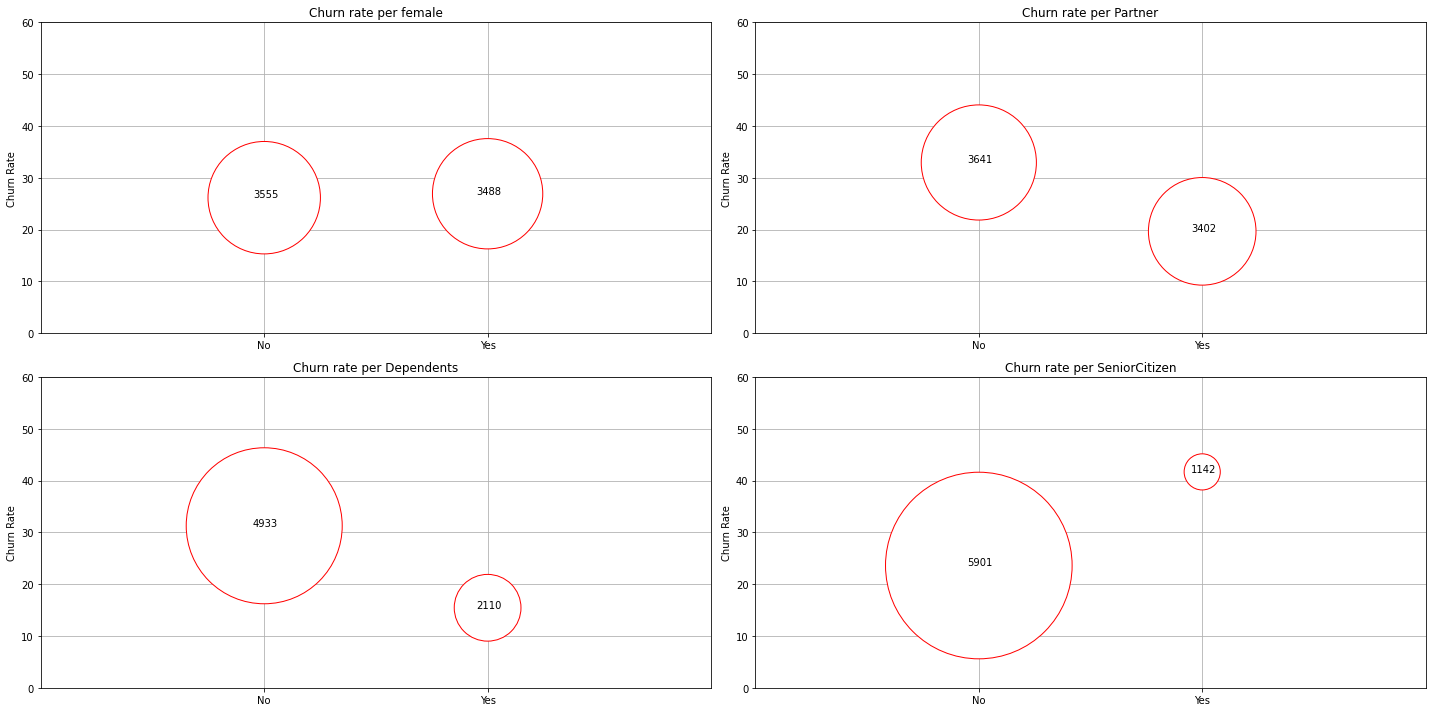

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(20,10))
plot_churn_per_attrib('female',0,0)
plot_churn_per_attrib('Partner',0,1)
plot_churn_per_attrib('Dependents',1,0)
plot_churn_per_attrib('SeniorCitizen',1,1)
fig.tight_layout()

## Analysis:
- senior citizens and single people are prone to churn
- no correlation between gender and churn rate

## 3.5 Billing-related Features

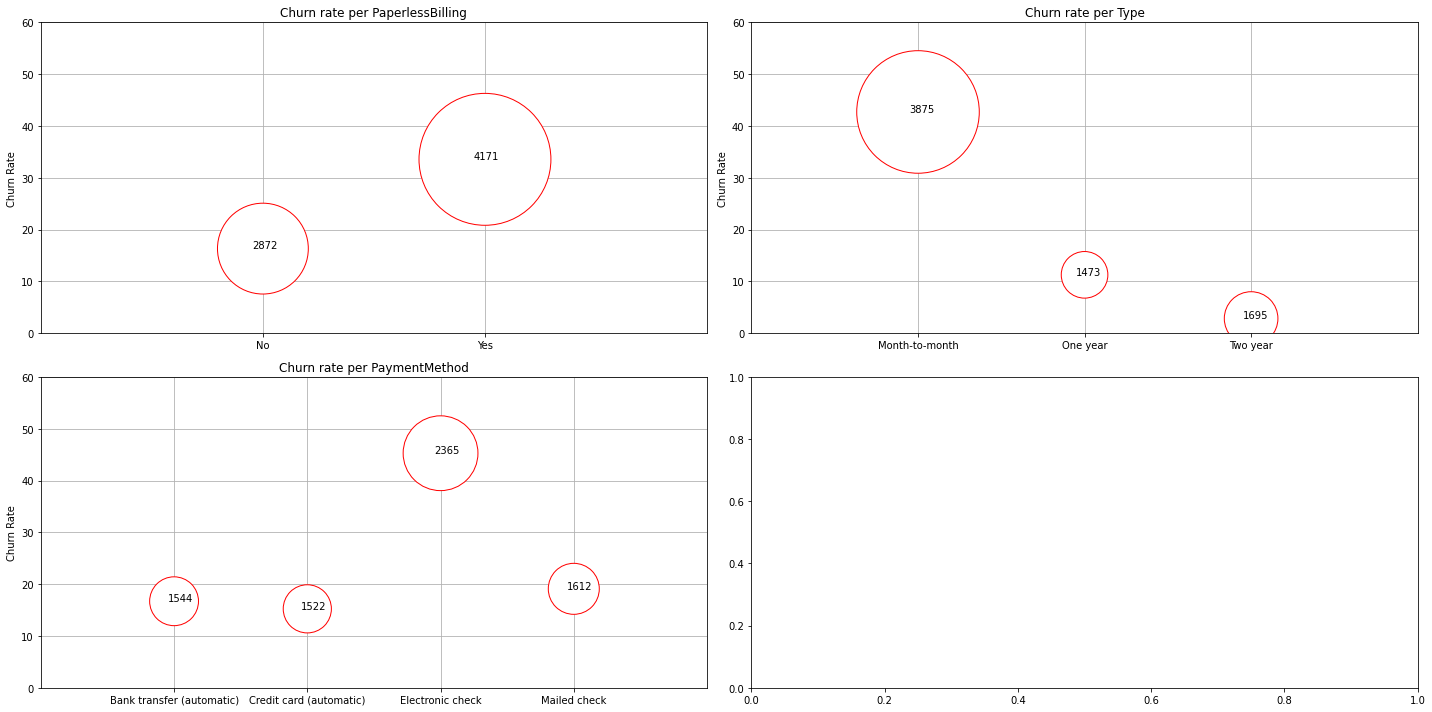

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(20,10))
plot_churn_per_attrib('PaperlessBilling',0,0)
plot_churn_per_attrib('Type', 0,1)
plot_churn_per_attrib('PaymentMethod',1, 0)
fig.tight_layout()

Charging per month:

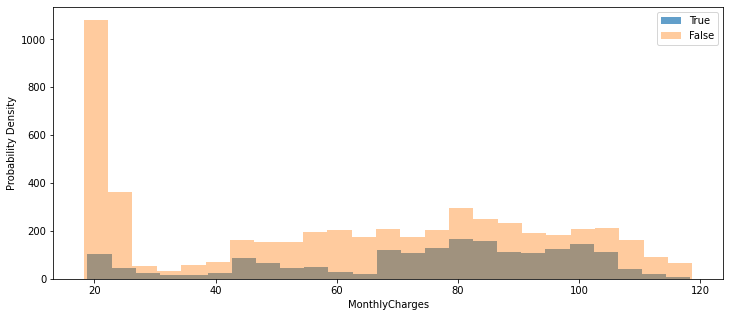

In [ ]:
nbins = 25
plt.figure(figsize=(12, 5))
sns.distplot(df_customer[df_customer['churn']==True]['MonthlyCharges'], label='True', hist = True, kde=False, bins=nbins,hist_kws={'alpha':0.7})
sns.distplot(df_customer[df_customer['churn']==False]['MonthlyCharges'], label='False', hist = True, kde=False, bins=nbins,hist_kws={'alpha':0.4})
plt.legend()
plt.xlabel('MonthlyCharges')
plt.ylabel('Probability Density');

## Analysis
- Paperless may imply churning.
- Month-to-month payment mean higher churn - no wonder, as there is less bonding
- Electronic check result in higher churn - when compared to automatic.
- No significant correlation between monthly charging and churn.

## 3.6 Service related Features

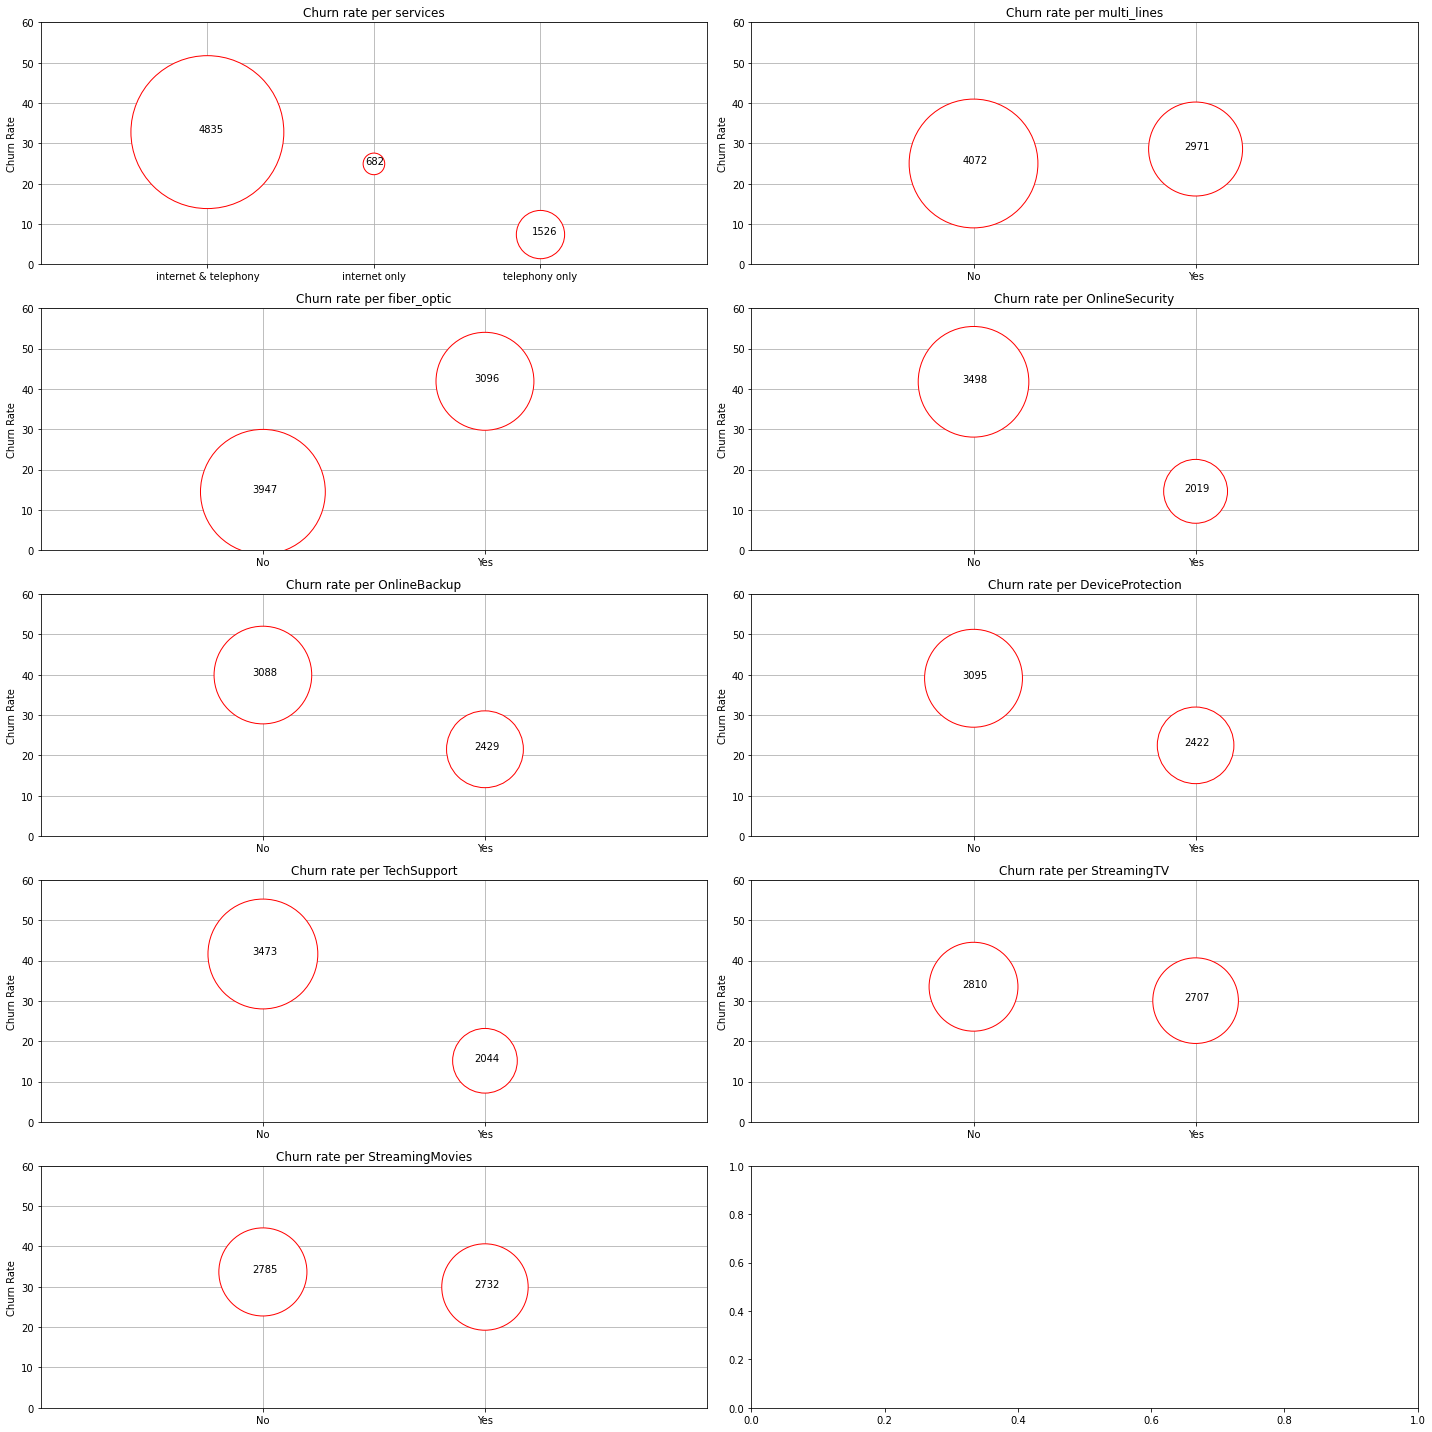

In [ ]:
fig, axs = plt.subplots(5,2,figsize=(20,20))
plot_churn_per_attrib('services', 0, 0)
plot_churn_per_attrib('multi_lines', 0, 1)
plot_churn_per_attrib('fiber_optic', 1, 0)
plot_churn_per_attrib('OnlineSecurity', 1, 1)
plot_churn_per_attrib('OnlineBackup', 2, 0)
plot_churn_per_attrib('DeviceProtection', 2, 1)
plot_churn_per_attrib('TechSupport', 3, 0)
plot_churn_per_attrib('StreamingTV', 3, 1)
plot_churn_per_attrib('StreamingMovies', 4, 0)
fig.tight_layout()

## Analysis
- customer having both internet and telephony services have higher churn
- Multi-line does not correlate with churn
- Fiber-optic have higher churn compared to DSL - this is something requiring attention - maybe there is a service quality issue.
- Customers who have the Online security, online backup and Tech support tend less to churn - it may show the benefit of these services.
- No correlation between streaming services and churning - seems customers do not appreciate these services.

## 3.7 Churn rate per retention period

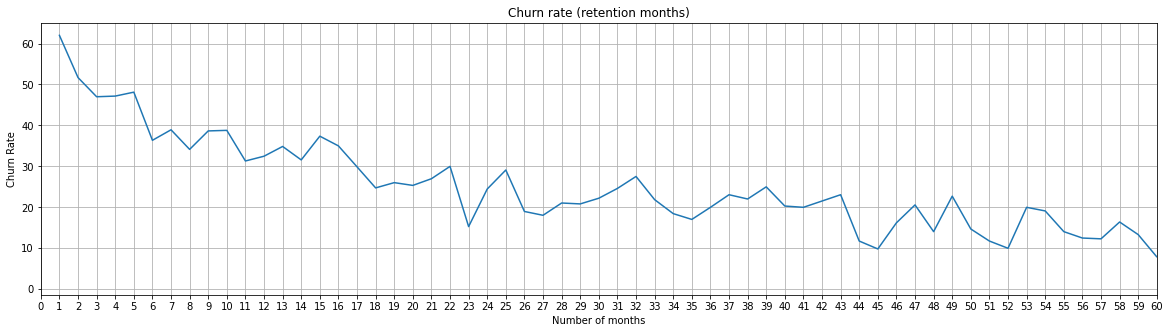

In [ ]:
data_pivot = df_customer.pivot_table(index=['retention_months'], columns='churn', values='customerID', aggfunc='count')
data_pivot['churn_rate'] = 100*data_pivot[1] / (data_pivot[0] + data_pivot[1])

ax = data_pivot['churn_rate'][1:].plot(figsize=(20, 5), grid=True, title = 'Churn rate (retention months)')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_ylabel('Churn Rate')
ax.set_xlabel('Number of months')
ax.set_xlim(left=0, right= 60);

## Analysis
As we can see above, churn rate decreases over the time. The first few months have high risk of churn - 60% in the first month!

## 3.8 Churn rate per time passed since begin of service

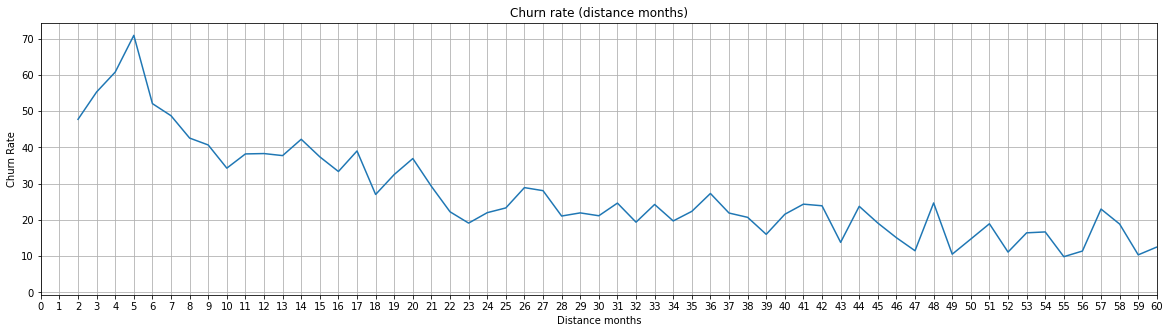

In [ ]:
data_pivot = df_customer.pivot_table(index=['begin_distance_months'], columns='churn', values='retention_months', aggfunc='count')
data_pivot['churn_rate'] = 100*data_pivot[1] / (data_pivot[0] + data_pivot[1])
ax = data_pivot['churn_rate'][1:].plot(figsize=(20, 5), grid=True, title = 'Churn rate (distance months)')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_ylabel('Churn Rate')
ax.set_xlabel('months passed since begin of the service')
ax.set_xlim(left=0, right= 60);

## Analysis
As can be clearly noted, there is a BIG churn problem in the last 6 months..

## 3.8 Filling missing values

# 4. Model

## 4.1 Preparations for modelling

### Filling missing values

In [ ]:
df_customer.fillna('No', inplace=True)

### Drop columns not required for model

In [ ]:
df_customer.drop(columns=['customerID', 'BeginDate', 'EndDate', 'TotalCharges', 'services'], inplace=True)

### One Hot Encoding

In [ ]:
data_ohe = pd.get_dummies(df_customer, drop_first=True)
data_ohe['has_telephony'] = data_ohe['has_telephony'].astype(int)
data_ohe['has_internet'] = data_ohe['has_internet'].astype(int)
data_ohe['churn'] = data_ohe['churn'].astype(int)

### Data Split
- Train: 60%
- Validation: 20%
- Test: 20%

In [ ]:
def split_groups (df, target_col):
    df_train, df_temp = train_test_split(df, test_size=0.4, random_state=12345)
    df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=12345)

    features_train = df_train.drop([target_col], axis=1)
    target_train = df_train[target_col]
    features_valid = df_valid.drop([target_col], axis=1)
    target_valid = df_valid[target_col]
    features_test = df_test.drop([target_col], axis=1)
    target_test = df_test[target_col]
    return features_train, target_train, features_valid, target_valid, features_test, target_test

features_train, target_train, features_valid, target_valid, features_test, target_test = split_groups (data_ohe, 'churn')

### Helper functions

In [ ]:
def learning_curve(train_scores, valid_scores, param_range, target):
    plt.figure(figsize=(9, 9))
    targets = [target]* len(train_scores)
    plt.plot(param_range, train_scores, 'o-', color="r", label="Training")
    plt.plot(param_range, valid_scores, 'o-', color="b", label="Validation")
    plt.plot(param_range, targets,'-', color="g", label="Target")
    plt.ylabel('Score') 
    plt.title('Learning Curve')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    eval_stats = {}
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        eval_stats[type] = {}
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)   # PRC
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    print(df_eval_stats)

## 4.2 Random Forest Model

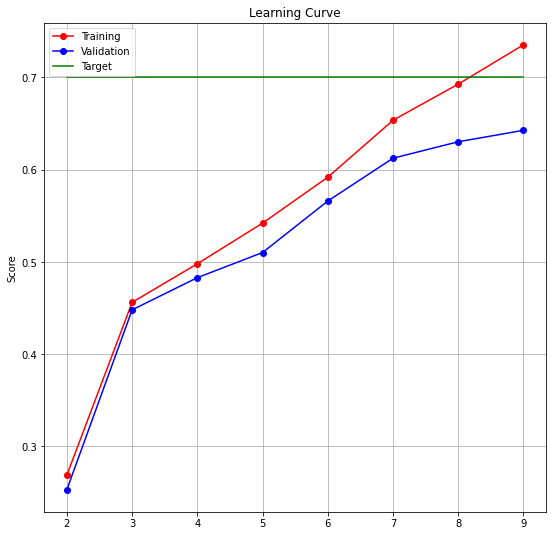

In [ ]:
train_f1_scores = []
valid_f1_scores = []
param_range = []
for depth in range(2,10):
    model = RandomForestClassifier(random_state=12345, max_depth=depth, class_weight=None)
    model.fit(features_train, target_train)
    param_range.append(depth)
    train_f1_scores.append(f1_score(target_train, model.predict(features_train)))
    valid_f1_scores.append(f1_score(target_valid, model.predict(features_valid)))
learning_curve(train_f1_scores, valid_f1_scores, param_range, 0.7)

As diplayed in above learning curve, value of `max_depth`=7' might be optimal, since overfit can be noticed at higher values.

               train        test
Accuracy        0.85        0.81
F1              0.65        0.57
APS             0.80        0.71
ROC AUC         0.92        0.86


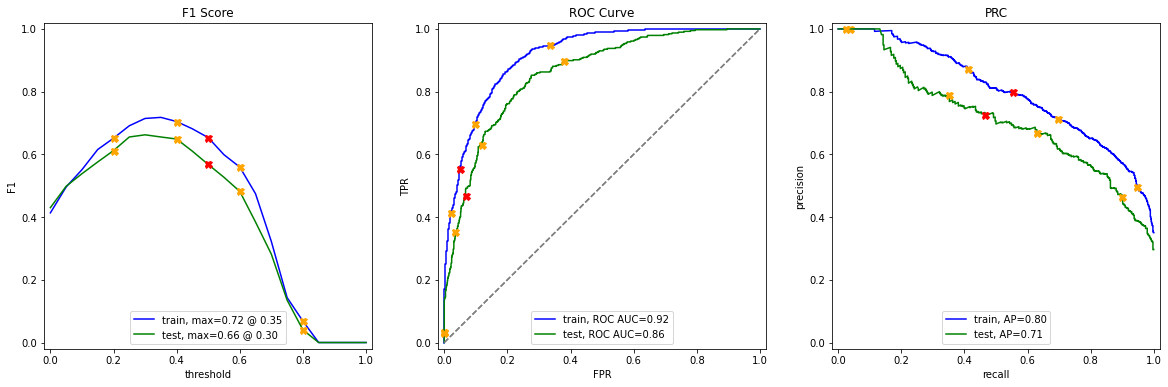

In [ ]:
model = RandomForestClassifier(random_state=12345, max_depth=7, class_weight=None)
model.fit(features_train, target_train)
evaluate_model(model, features_train, target_train, features_test, target_test)

## 4.3 CatBoost Model

Learning rate set to 0.5
0:	learn: 0.4693455	total: 4.18ms	remaining: 29.3ms
3:	learn: 0.3415980	total: 14ms	remaining: 14ms
6:	learn: 0.3026021	total: 26.2ms	remaining: 3.75ms
7:	learn: 0.2964199	total: 31.4ms	remaining: 0us
               train        test
Accuracy        0.88        0.85
F1              0.73        0.67
APS             0.85        0.81
ROC AUC         0.92        0.89


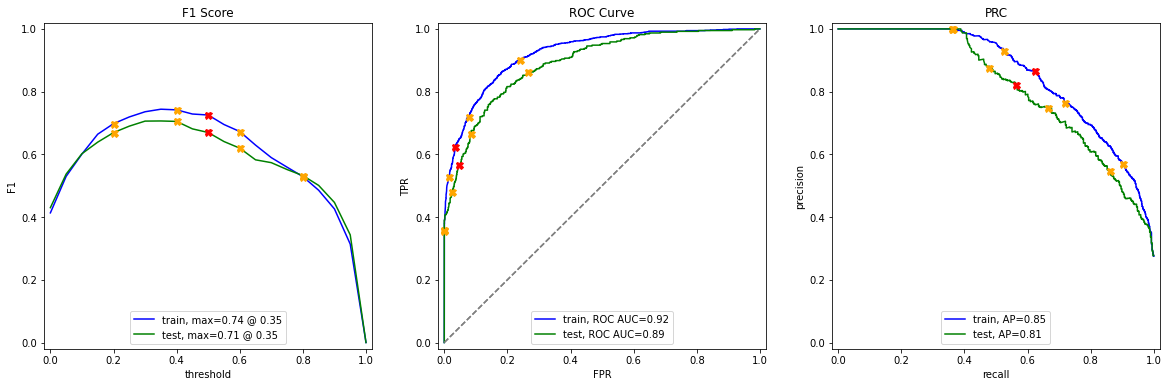

In [ ]:
model = CatBoostClassifier(loss_function="Logloss", iterations=8)
model.fit(features_train, target_train, verbose=3)
#pred_valid = model.predict(features_valid)

evaluate_model(model, features_train, target_train, features_test, target_test)

## 4.4 XGBoost Model

               train        test
Accuracy        0.91        0.85
F1              0.79        0.66
APS             0.93        0.82
ROC AUC         0.96        0.90


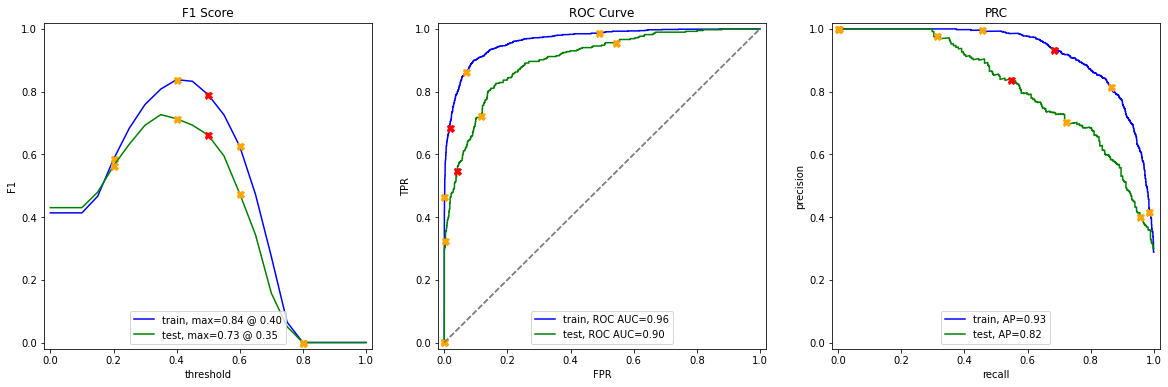

In [ ]:
import xgboost as xgb
model = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 12, alpha = 10, n_estimators = 15)
model.fit(features_train, target_train, verbose=3)
evaluate_model(model, features_train, target_train, features_test, target_test)

## 4.5 Modeling results analysis:


| Model         | ROC-AUC |Accuracy |
| :------------ | ---- |---- |
| Random Forest |0.86  |0.81  |
| CatBoost      |0.89  |0.85  
| XGBoost       |0.90  |0.85  |

As can be clearly seen - XGBoost, provides the best results.

# 5. Summary and Conclusions
**High churn rate, especially in the last 6 months.**

High churn rate on:

- Singles with no dependents
- Senior citizens
- Paperless billing reports
- Payment plan: month-by-month
- Payment method: electronic check
- Internet infrastructure: fiber-optics (may point quality of service issues)
- Customer with no value added Internet features (except streaming).
- New customers in the first 36 months
- Customers who joined in the last 6 months.

# 5. Questions and Project Plan

## Questions:
Please let know if following assumptions are correct:
- If EndDate = No then no churn, otherwise: churn
- If MultipleLines = Null, then customer have Internet Service, but no telephone service.
- If InternetService = Null, then customer have telephone service, but no internet

## Project Plan:

1. 13/09    Submit EDA and Project Plan
2. 13-16/09 Coding
3. 16/09    Code submission
4. 17-18/09 Report preparation
5. 18/09    Report submission
6. 18-19/09 Peer-to-peer review
7. 20-21/09 Preparation of final project
5. 22/09    Final project submission